<a href="https://colab.research.google.com/github/haedal-uni/analysis/blob/main/250404_%EB%AF%B8%EA%B5%AD_%EC%B2%A0%EA%B0%95_%EC%BD%94%EC%9D%BC_%EC%84%A0%EB%AC%BC_%EA%B3%BC%EA%B1%B0_%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 경고 메시지 무시하기
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 노트북이 코랩에서 실행 중인지 체크
import sys
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [ ]:
import matplotlib

matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
# 2015-03-03 ~ 2025-04-03
import pandas as pd
df = pd.read_csv('미국 철강 코일 선물 과거 데이터.csv', parse_dates=['날짜'], index_col="날짜", thousands=",") # 구분자 제거
df.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2025-04-02,915.0,915.0,920.0,897.0,0.09K,2.23%
2025-04-01,895.0,894.0,895.0,894.0,0.07K,0.56%
2025-03-31,890.0,895.0,895.0,890.0,0.01K,0.00%
2025-03-28,890.0,895.0,899.0,890.0,0.08K,0.00%
2025-03-27,890.0,895.0,896.0,882.0,0.29K,-1.66%


종가 : 주식 시장에서 하루 거래가 종료될 때 마지막으로 거래된 가격

시가 : 최초에 체결되는 거래가격

In [ ]:
df.shape

(2555, 6)

In [ ]:
df.isna().sum()

,0
종가,0
시가,0
고가,0
저가,0
거래량,883
변동 %,0


In [ ]:
# 결측치 확인
(883/2555)*100

34.55968688845401

결측치가 전체 데이터의 34.6%를 차지

ARIMA 모델은 종가 데이터만을 기반으로 학습하고 예측을 수행하기 때문에

거래량의 결측치는 모델 성능에 영향을 미치지 않으므로 결측치 제거X

In [ ]:
# # 결측치 제거
# df.dropna(inplace=True)

In [ ]:
df.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2025-04-02,915.0,915.0,920.0,897.0,0.09K,2.23%
2025-04-01,895.0,894.0,895.0,894.0,0.07K,0.56%
2025-03-31,890.0,895.0,895.0,890.0,0.01K,0.00%
2025-03-28,890.0,895.0,899.0,890.0,0.08K,0.00%
2025-03-27,890.0,895.0,896.0,882.0,0.29K,-1.66%


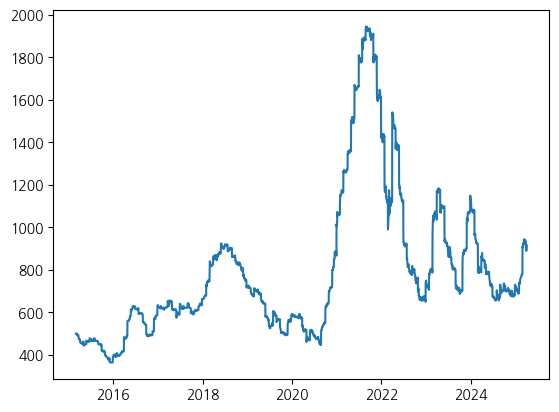

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['종가'].values)

In [ ]:
df.describe()

,종가,시가,고가,저가
count,2555.000000,2555.000000,2555.00000,2555.000000
mean,793.527202,793.533464,795.92681,791.071233
std,345.805086,345.665411,347.03683,344.351359
min,364.000000,364.000000,364.00000,364.000000
25%,575.000000,575.000000,576.50000,573.000000
50%,697.000000,697.000000,699.00000,693.000000
75%,895.000000,895.000000,898.00000,892.000000
max,1945.000000,1945.000000,1945.00000,1943.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2555 entries, 2025-04-02 to 2015-03-03
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      2555 non-null   float64
 1   시가      2555 non-null   float64
 2   고가      2555 non-null   float64
 3   저가      2555 non-null   float64
 4   거래량     1672 non-null   object 
 5   변동 %    2555 non-null   object 
dtypes: float64(4), object(2)
memory usage: 139.7+ KB


80%, 20% 고정 후 p, d, q의 조합 찾기

order=(1,1,1) → MSE: 136007.3529578253
order=(1,1,2) → MSE: 136471.33535754273
order=(1,2,1) → MSE: 3214981.9824777995
order=(1,2,2) → MSE: 3098604.6961116926
order=(2,1,1) → MSE: 135657.68496608108
order=(2,1,2) → MSE: 135657.19935174825
order=(2,2,1) → MSE: 3479893.1249916046
order=(2,2,2) → MSE: 3196897.941093872

최적의 order 값: (np.int64(2), np.int64(1), np.int64(2)), 최소 MSE: 135657.19935174825
                               SARIMAX Results                                
Dep. Variable:                     종가   No. Observations:                 2044
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8932.408
Date:                Thu, 03 Apr 2025   AIC                          17874.817
Time:                        01:37:41   BIC                          17902.927
Sample:                             0   HQIC                         17885.127
                               - 2044                                         
Covariance Type:                  opg          

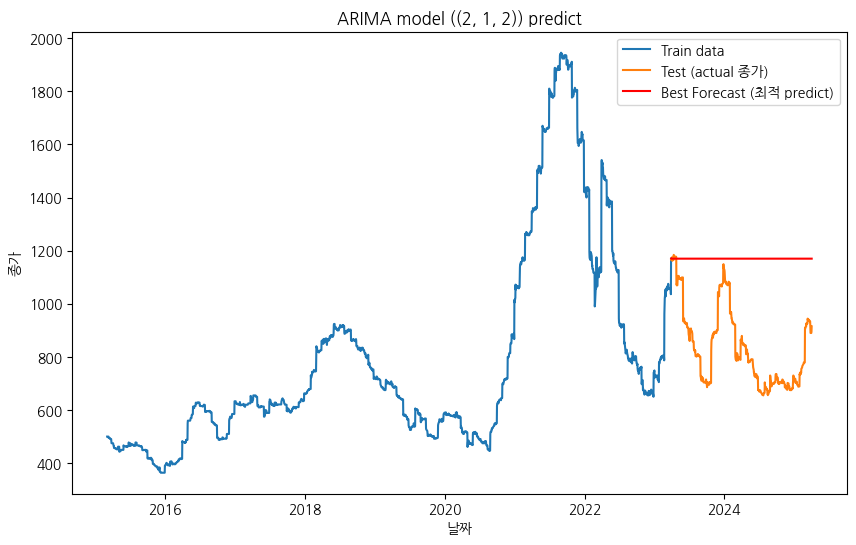

In [ ]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 데이터 불러오기 및 정렬
df = df.sort_index()
closing_prices = df['종가']

# 훈련과 테스트 세트 분할
split_index = int(len(closing_prices) * 0.8)
train = closing_prices.iloc[:split_index]
test = closing_prices.iloc[split_index:]

'''
p: 자기회귀(AR) 차수, 과거의 값을 얼마나 반영할 것인지 결정.
d: 차분 차수, 데이터의 차분을 몇 번 할지 결정하여 비정상성을 제거.
q: 이동평균(MA) 차수, 예측 오차를 얼마나 반영할지 결정.
'''
# p, d, q의 조합 생성 (1~2 범위 지정)
p_range = np.arange(1, 3)  # [1, 2]
d_range = np.arange(1, 3)  # [1, 2]
q_range = np.arange(1, 3)  # [1, 2]
best_mse = float("inf") # 양의 무한대
best_order = None

# 모든 조합에 대해 반복 실행
for p, d, q in itertools.product(p_range, d_range, q_range): # 모든 조합을 하나씩 순회하며 사용(데카르트 곱)
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)

        # 더 낮은 MSE를 찾으면 갱신(MSE는 오차가 작을수록 모델의 예측이 실제 데이터에 더 잘 맞는 것을 의미)
        if mse < best_mse:
            best_mse = mse
            best_order = (p, d, q)

        print(f"order=({p},{d},{q}) → MSE: {mse}")

    except Exception as e:
        print(f"order=({p},{d},{q})에서 오류 발생: {e}")

print(f"\n최적의 order 값: {best_order}, 최소 MSE: {best_mse}")

# 최적 모델 학습
best_model = ARIMA(train, order=best_order)
best_model_fit = best_model.fit()
best_forecast = best_model_fit.forecast(steps=len(test))
print(best_model_fit.summary())

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train data')
plt.plot(test.index, test, label='Test (actual 종가)')
plt.plot(test.index, best_forecast, label='Best Forecast (최적 predict)', color='red')
plt.title(f"ARIMA model ({tuple(map(int, best_order))}) predict") # map(적용할 함수, 반복 가능한 자료형)
plt.xlabel("날짜")
plt.ylabel("종가")
plt.legend()
plt.show()


In [ ]:
split_ratios = [0.6, 0.7, 0.8, 0.9]
best_mse = float("inf")
best_order = None
best_ratio = None

for ratio in split_ratios:
    split_index = int(len(closing_prices) * ratio)
    train = closing_prices.iloc[:split_index]
    test = closing_prices.iloc[split_index:]

    # 기존 코드 반복
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            mse = mean_squared_error(test, forecast)

            if mse < best_mse:
                best_mse = mse
                best_order = (p, d, q)
                best_ratio = ratio

        except Exception as e:
            print(f"order=({p},{d},{q})에서 오류 발생: {e}")


print(f"\n최적의 분할 비율: {best_ratio}, 최적의 order 값: {tuple(map(int, best_order))}, 최소 MSE: {best_mse}")



최적의 분할 비율: 0.9, 최적의 order 값: (2, 2, 1), 최소 MSE: 10556.930504394924


In [ ]:
tuple(map(int, best_order))[0]

2

train, test 데이터 및 order 값 최적 데이터로 분석

                               SARIMAX Results                                
Dep. Variable:                     종가   No. Observations:                 2299
Model:                 ARIMA(2, 2, 1)   Log Likelihood              -10093.387
Date:                Thu, 03 Apr 2025   AIC                          20194.774
Time:                        02:49:00   BIC                          20217.731
Sample:                             0   HQIC                         20203.144
                               - 2299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0064      0.023     -0.275      0.783      -0.052       0.039
ar.L2         -0.0169      0.037     -0.450      0.653      -0.090       0.057
ma.L1         -0.9859      0.003   -382.688      0.0

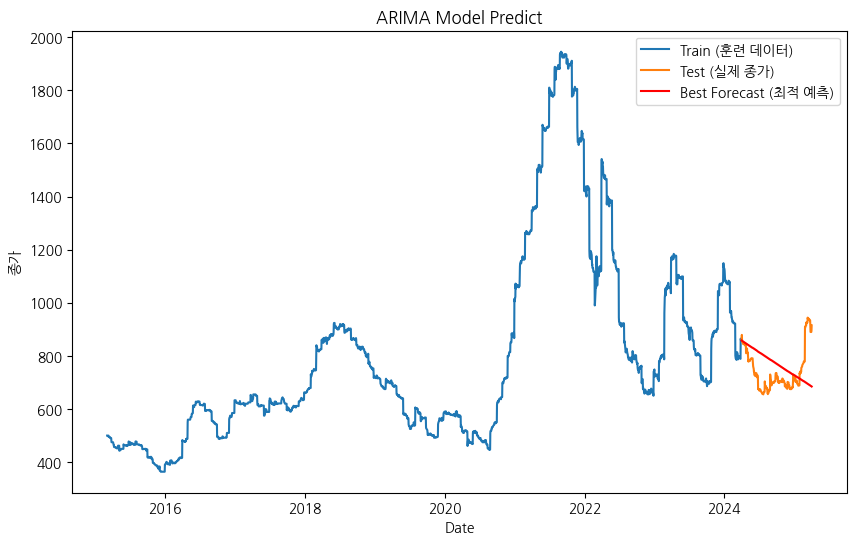

In [ ]:
split_index = int(len(closing_prices) * best_ratio)
# train, test
train = closing_prices.iloc[:split_index]
test = closing_prices.iloc[split_index:]

p = tuple(map(int, best_order))[0]
d = tuple(map(int, best_order))[1]
q = tuple(map(int, best_order))[2]

# ARIMA 모델 구성 및 학습
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# 테스트 기간에 대한 예측 (예측 스텝 수는 테스트 세트 길이와 동일)
forecast = model_fit.forecast(steps=len(test))

# 예측 성능 평가 (평균 제곱 오차)
print("Mean Squared Error:", best_mse)

# 실제 종가와 예측 종가 시각화
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train (훈련 데이터)')
plt.plot(test.index, test, label='Test (실제 종가)')
plt.plot(test.index, forecast, label='Best Forecast (최적 예측)', color='red')
plt.title("ARIMA Model Predict")
plt.xlabel("Date")
plt.ylabel("종가")
plt.legend()
plt.show()

위 그래프를 보고 2022년도 그래프 폭이 커서 2023년부터 최근으로 실행함

In [ ]:
# 2023 ~ 2025년의 데이터로만 실행해보기
df_23_25 = df[(df.index >= '2023-01-01') & (df.index <= '2025-12-31')]
df_23_25.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2023-01-01,749.0,749.0,749.0,749.0,NaN,0.67%
2023-01-03,722.0,744.0,744.0,720.0,0.13K,-3.60%
2023-01-04,723.0,726.0,728.0,717.0,0.11K,0.14%
2023-01-05,725.0,728.0,730.0,725.0,0.10K,0.28%
2023-01-06,730.0,728.0,731.0,725.0,0.02K,0.69%


In [ ]:
df_23_25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 574 entries, 2023-01-01 to 2025-04-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      574 non-null    float64
 1   시가      574 non-null    float64
 2   고가      574 non-null    float64
 3   저가      574 non-null    float64
 4   거래량     503 non-null    object 
 5   변동 %    574 non-null    object 
dtypes: float64(4), object(2)
memory usage: 31.4+ KB



최적의 분할 비율: 0.6, 최적의 order 값: (2, 1, 1), 최소 MSE: 6179.650309963157
                               SARIMAX Results                                
Dep. Variable:                     종가   No. Observations:                  344
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1573.334
Date:                Thu, 03 Apr 2025   AIC                           3154.668
Time:                        03:01:37   BIC                           3170.019
Sample:                             0   HQIC                          3160.783
                                - 344                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9376      0.187      5.016      0.000       0.571       1.304
ar.L2          0.0151      0.103      0.146      0.884      -0.1

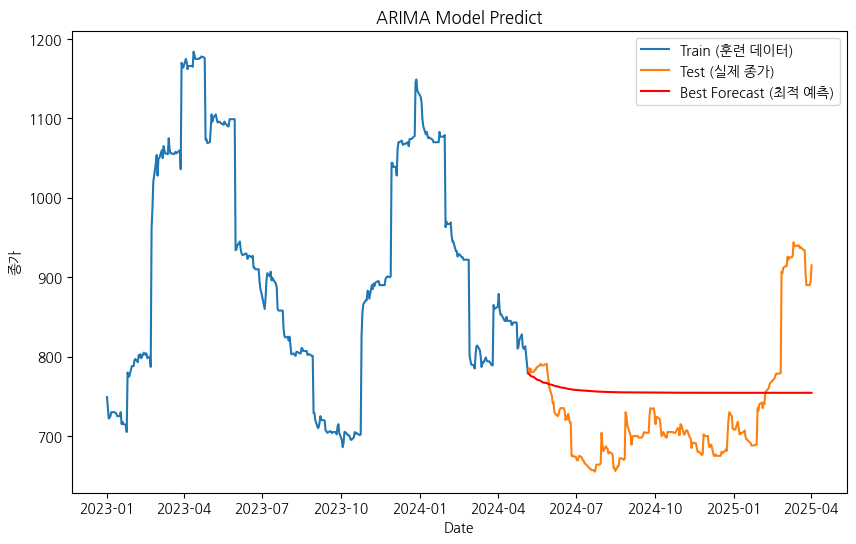

In [ ]:
df_23_25 = df_23_25.sort_index()
closing_prices = df_23_25['종가']
split_ratios = [0.6, 0.7, 0.8, 0.9]
best_mse = float("inf")
best_order = None
best_ratio = None

for ratio in split_ratios:
    split_index = int(len(closing_prices) * ratio)
    train = closing_prices.iloc[:split_index]
    test = closing_prices.iloc[split_index:]

    # 기존 코드 반복
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            mse = mean_squared_error(test, forecast)

            if mse < best_mse:
                best_mse = mse
                best_order = (p, d, q)
                best_ratio = ratio

        except Exception as e:
            print(f"order=({p},{d},{q})에서 오류 발생: {e}")


print(f"\n최적의 분할 비율: {best_ratio}, 최적의 order 값: {tuple(map(int, best_order))}, 최소 MSE: {best_mse}")



split_index = int(len(closing_prices) * best_ratio)
# train, test
train = closing_prices.iloc[:split_index]
test = closing_prices.iloc[split_index:]

p = tuple(map(int, best_order))[0]
d = tuple(map(int, best_order))[1]
q = tuple(map(int, best_order))[2]

# ARIMA 모델 구성 및 학습
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# 테스트 기간에 대한 예측 (예측 스텝 수는 테스트 세트 길이와 동일)
forecast = model_fit.forecast(steps=len(test))

# 예측 성능 평가 (평균 제곱 오차)
print("Mean Squared Error:", best_mse)

# 실제 종가와 예측 종가 시각화
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train (훈련 데이터)')
plt.plot(test.index, test, label='Test (실제 종가)')
plt.plot(test.index, forecast, label='Best Forecast (최적 예측)', color='red')
plt.title("ARIMA Model Predict")
plt.xlabel("Date")
plt.ylabel("종가")
plt.legend()
plt.show()


23년 ~ 24년 5월 까지는 비슷한 분포 형태로 보임

24년 5월 이후 데이터 활용

In [ ]:
df_24_25 = df[(df.index >= '2024-05-01') & (df.index <= '2025-12-31')]
df_24_25.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2024-05-01,810.0,811.0,811.0,800.0,0.42K,-0.37%
2024-05-02,810.0,805.0,810.0,805.0,0.07K,0.00%
2024-05-03,813.0,813.0,813.0,813.0,0.00K,0.37%
2024-05-06,779.0,800.0,800.0,779.0,0.06K,-4.18%
2024-05-07,785.0,790.0,790.0,785.0,0.04K,0.77%


In [ ]:
df_24_25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2024-05-01 to 2025-04-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      234 non-null    float64
 1   시가      234 non-null    float64
 2   고가      234 non-null    float64
 3   저가      234 non-null    float64
 4   거래량     202 non-null    object 
 5   변동 %    234 non-null    object 
dtypes: float64(4), object(2)
memory usage: 12.8+ KB



최적의 분할 비율: 0.9, 최적의 order 값: (1, 1, 2), 최소 MSE: 475.2322721979251
                               SARIMAX Results                                
Dep. Variable:                     종가   No. Observations:                  210
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -831.132
Date:                Thu, 03 Apr 2025   AIC                           1670.263
Time:                        03:03:15   BIC                           1683.633
Sample:                             0   HQIC                          1675.669
                                - 210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5701      1.934     -0.295      0.768      -4.361       3.221
ma.L1          0.5587      1.926      0.290      0.772      -3.2

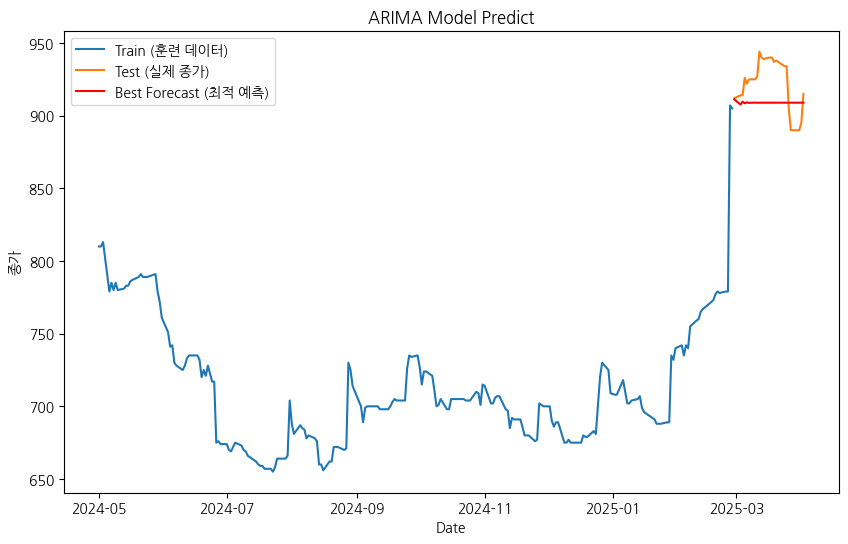

In [ ]:
df_24_25 = df_24_25.sort_index()
closing_prices = df_24_25['종가']
split_ratios = [0.6, 0.7, 0.8, 0.9]
best_mse = float("inf")
best_order = None
best_ratio = None

for ratio in split_ratios:
    split_index = int(len(closing_prices) * ratio)
    train = closing_prices.iloc[:split_index]
    test = closing_prices.iloc[split_index:]

    # 기존 코드 반복
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            mse = mean_squared_error(test, forecast)

            if mse < best_mse:
                best_mse = mse
                best_order = (p, d, q)
                best_ratio = ratio

        except Exception as e:
            print(f"order=({p},{d},{q})에서 오류 발생: {e}")


print(f"\n최적의 분할 비율: {best_ratio}, 최적의 order 값: {tuple(map(int, best_order))}, 최소 MSE: {best_mse}")


split_index = int(len(closing_prices) * best_ratio)
# train, test
train = closing_prices.iloc[:split_index]
test = closing_prices.iloc[split_index:]

p = tuple(map(int, best_order))[0]
d = tuple(map(int, best_order))[1]
q = tuple(map(int, best_order))[2]

# ARIMA 모델 구성 및 학습
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# 테스트 기간에 대한 예측 (예측 스텝 수는 테스트 세트 길이와 동일)
forecast = model_fit.forecast(steps=len(test))

# 예측 성능 평가 (평균 제곱 오차)
print("Mean Squared Error:", best_mse)

# 실제 종가와 예측 종가 시각화
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train (훈련 데이터)')
plt.plot(test.index, test, label='Test (실제 종가)')
plt.plot(test.index, forecast, label='Best Forecast (최적 예측)', color='red')
plt.title("ARIMA Model Predict")
plt.xlabel("Date")
plt.ylabel("종가")
plt.legend()
plt.show()
